# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer:**

Based on the discrete (categorical) nature of the output (binary labels) this is a classification problem. We are trying to determine which elements of the dataset (students) have a fail (0) or pass (1) value given a set of features. On the contrary regression problems deal with a continuous output, whether the inputs, or rather features, are categorical or numerical.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler


# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
print student_data

Student data read successfully!
    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
5       GP   M   16       U     LE3       T     4     3  services     other   
6       GP   M   16       U     LE3       T     2     2     other     other   
7       GP   F   17       U     GT3       A     4     4     other   teacher   
8       GP   M   15       U     LE3       A     3     2  services     other   
9       GP   M   15       U     GT3       T     3     4     other     other   
10      GP   F   15       U     GT3       T     4     4   teacher    health   
11      GP   F   15 

### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# TODO: Calculate number of students
n_students = len(student_data.index)

# TODO: Calculate number of features
n_features = len(student_data.columns)

# TODO: Calculate passing students
n_passed = len(student_data.loc[student_data['passed'] == 'yes'].index)

# TODO: Calculate failing students
n_failed = len(student_data.loc[student_data['passed'] == 'no'].index)

# TODO: Calculate graduation rate
grad_rate = n_passed*100/(n_passed+n_failed)

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 31
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.00%


In this binary classifcation the output populations are fairly balanced (265 positives versus 130 negatives) which minimizes the possiblity of overfitting for one or other result, usually caused by having the population skewed to either positive or negative results.  

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [3]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all_pre = preprocess_features(X_all)
scaler1=MinMaxScaler()
X_all=pd.DataFrame(scaler1.fit_transform(X_all_pre), columns=X_all_pre.columns, index=X_all_pre.index)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# TODO: Import any additional functionality you may need here
#from sklearn import cross_validation
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
# TODO: Set the number of training points
num_train = 300
rstate=333

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above

#X_all_shuffled, y_all_shuffled=shuffle(X_all,y_all, random_state=rstate)
X_all_shuffled, y_all_shuffled=X_all,y_all

#a,b,c,d=cross_validation.cross_val_score(clf, iris.data, iris.target, cv=cv)

a,b,c,d=train_test_split(X_all_shuffled, y_all_shuffled,test_size=num_test,random_state=rstate)

X_train = a
X_test = b
y_train = c
y_test = d

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

__OBSERVATION__: Five models have been chosen (instead of three) because of the importance of comparing their characteristics on the dataset. In addition, all 7 proposed models have been analyzed to provide a more complete picture. The selected models are indicated by a label next to their names.

**Answer: **

__(Selected) Gaussian Naive Bayes__: GNB is the implementation of the Bayes classifier using the Bayes' theorem and the 'naive' assumption that the proability of the features, given the result, are independent from each other.

_Real World Application_: Naive Bayes Classifier is being used for efficient inference in large models for research and medical cases, ['5 Algorithms That Are Transforming The Healthcare Industry'](http://www.pcquest.com/5-algorithms-that-are-transforming-the-healthcare-industry/) . 

_Advantages_: This classifier has high bias and low variance duea to its simplicity, making it ideal for fast calculations. GNB performs surprisingly well with a relatively small training data set and has a simple interpretation.

_Weaknesses_: Due to its simplicity GNB tends to perform badly as data size increases, being impervious to the emerging complexities of the dataset. 

_Present Problem_: With a relatively high number of features (multidimensional problem), GNB should perform relatively well in computational time and it is known for having great accuracy with binary classification despite its simplicity.

__K Nearest Neighbors__:The KNN technique is a nonparametric method that relies on calculating the average output (or most likely) of all vectors near the features requiring prediction, in the feature space.

_Real World Application_: KNN algorithms are used to build costumer personas. A customer persona is a thorough understanding of who you are selling to so you can deliver the proper digital experience, [A Guide to Understanding Customer Personas](https://www.cmscritic.com/understanding-customer-personas/).

_Advantages_: Highly flexible since no model is required.

_Weaknesses_: KNN requires large amount of data for great accuracy and presents high variance in feature regions with low data density. In addition, KNN performs poorly with linear relationships.

_Present Problem_: Due to its flexibility KNN has the potential for good performance. However, KNN also shows long prediction time and proclivity to high variance, both areas in which some of the other models have better performance.

__ (Selected) Logistic Regression__: Despite its name LR is a model used for binary classification. Logistic Regression utilizes a probablity model based on an exponential function monotonically joining 0 and 1.

_Real World Application_: For recommendations, Youtube first uses a neural network to reduce the number of videos (down to a few hundreds) and then put them through a logistic regression model to score each video and ranking them. [How YouTube's Recommendation Algorithm Works](https://www.infoq.com/news/2016/09/How-YouTube-Recommendation-Works)

_Advantages_: Ease of interpretation. Less prone to overfitting.

_Weaknesses_: Low flexibility compared to other models. Better suited for single decision boundaries.

_Present Problem_: In addition to linear behavior LR can learn nonlinearities, to an extent. LR is also computationaly fast and does not overfit easily.

__(Selected) Stochastic Gradient Descent__:  Updates a set of parameters minimizing the error function. Is usually utilized to improve linear regressions by saving processing resources and assuring convergence.

_Real World Application_: Dealerships obtain marketing insights, sales benefits, and customer-retention gains using big data and analytics that use Stochastic Gradient Descent,[Big Data Keeps Your Dealership a Step Ahead of the Customer](http://www.dealermarketing.com/big-data-keeps-your-dealership-a-step-ahead-of-the-customer/)

_Advantages_: Efficient and flexible, since it has a large number of tunning knobs.

_Weaknesses_: Large number of hyperparameters need to be tuned. Convergence is sensitivite to high dimensional features, potentially increasing processing times and resulting in high variance.

_Present Problem_: For this problem, the number of features is relatively large which may negatively impact the learning rate of SGD, as well as its convergence, decreasing its performance.

__ (Selected) Decision Trees__: DT uses a tree-like decision model to produce the map features to conclusions about the target value.

_Real World Application_:What we want to do is extract as much information as we can from the vast number of failed reactions that usually don’t get reported, [Lab Failures Turn to Gold in Search for New Materials](https://www.scientificamerican.com/article/lab-failures-turn-to-gold-in-search-for-new-materials/)

_Advantages_: Simple implementation and interpretation with boolean logic. Decision Trees perform well when the boundary decision is non linear. Processing time increases loghatihmicalyly with data size.

_Weaknesses_: DT performes poorly when boundaries are linear, because it does not naturally take advantage of the linearity of the data feature space. Prediction accuracy is not high compared to other techniques and it tends to overfit.

_Present Problem_: For this problem, DT's flexibility and short prediction time could prove advantageous. DT also has the danger of overfitting, but it could take advantage of the nonlinearities from the dataset and ourperform the other models.

__Random Forest__: RF improves the accuracy and prevents overfitting in decision trees.

_Real World Application_: Random Forest is utilized to identify problem officers BEFORE an incident takes place, [Big Data And Bad Cops: Can An Algorithm Predict Police Misconduct?](http://wcqs.org/post/big-data-and-bad-cops-can-algorithm-predict-police-misconduct-part-1#stream/0)

_Advantages_: Same advantages as decision trees plus improved accuracy.

_Weaknesses_: Same weakneses of decision trees. In addition the added complexity means longer processing time.

_Present Problem_: For this problem RF could improve accuracy of DT results but at a cost of requiring more resources and taking a longer time to calculate.

__(Selected) SVM (SVC)__: SVM is the generalization of the maximal margin classifier and it can use linear and non-linear classifiers.

_Real World Application_:Netflix uses a new metric by combining multiple elementary quality metrics and fusing them together with a machine-learning algorithm, specifically a Support Vector Machine (SVM) regressor, [Netflix introduces new quality metric](http://www.streamingmedia.com/Articles/News/Online-Video-News/Netflix-Introduces-New-Quality-Metric-111564.aspx)

_Advantages_: Well suited for high dimensional spaces and allows for different kernels.

_Disadvantages_: Sensitive to features/samples ratio and probability estimates are calculated indirectly with extra computational resources.

_Present Problem_: SVC is very well suited for this dataset, with its high dimensionality capabilities and flexibility. 


### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [6]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    traintime=end-start
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(traintime)
    
    return traintime

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    
    calctime=end-start
    
    print "Made predictions in {:.4f} seconds.".format(calctime)
    return f1_score(target.values, y_pred, pos_label='yes'),calctime


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_time=train_classifier(clf, X_train, y_train)
    
    
    
    # Print the results of prediction for both training and testing
    predict_train, time_predict_train=predict_labels(clf, X_train, y_train)
    predict_test, time_predict_test=predict_labels(clf, X_test, y_test)
    
    results=[train_time, time_predict_test, predict_train, predict_test]
    
    
    print "F1 score for training set: {:.4f}.".format(predict_train)
    print "F1 score for test set: {:.4f}.".format(predict_test)
    
    return results

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [7]:
# TODO: Import the three supervised learning models from sklearn



from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import collections
import PrettyTable as pt
import numpy as np


# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = RandomForestClassifier(random_state=rstate, n_jobs=1)
clf_C = LogisticRegression(random_state=rstate,n_jobs=1)
clf_D = SGDClassifier(random_state=rstate,n_jobs=1)
clf_E = SVC(random_state=rstate)
clf_F = DecisionTreeClassifier(random_state=rstate)
clf_G = KNeighborsClassifier(n_jobs=1)


# TODO: Set up the training set sizes

X_total=pd.concat([X_train,X_test])
y_total=pd.concat([y_train,y_test])

X_train_300, X_test_95, y_train_300, y_test_95=X_train, X_test, y_train, y_test
X_train_200, X_test_195, y_train_200, y_test_195=X_total[0:200], X_total[200:395], y_total[0:200], y_total[200:395]
X_train_100, X_test_295, y_train_100, y_test_295=X_total[0:100], X_total[100:395], y_total[0:100], y_total[100:395]



print (X_train_300.shape, X_test_95.shape, y_train_300.shape, y_test_95.shape)
print (X_train_200.shape, X_test_195.shape, y_train_200.shape, y_test_195.shape)
print (X_train_100.shape, X_test_295.shape, y_train_100.shape, y_test_295.shape)


letters=[clf_A,clf_B,clf_C,clf_D,clf_E,clf_F,clf_G]

finaltablelist=[]

for i in letters:
                       
    line3=train_predict(i, X_train_300,y_train_300,X_test_95,y_test_95)
    line2=train_predict(i, X_train_200,y_train_200,X_test_195,y_test_195)
    line1=train_predict(i, X_train_100,y_train_100,X_test_295,y_test_295)
    
    line1=["{0:.2g}".format(item) for item in line1]
    line2=["{0:.2g}".format(item) for item in line2]
    line3=["{0:.2g}".format(item) for item in line3]
    
    line1.insert(0,'100')
    line2.insert(0,'200')
    line3.insert(0,'300')

    data = [line1,line2,line3]
    finaltablelist.append(data)
    

((300, 48), (95, 48), (300,), (95,))
((200, 48), (195, 48), (200,), (195,))
((100, 48), (295, 48), (100,), (295,))
Training a GaussianNB using a training set size of 300. . .
Trained model in 0.0023 seconds
Made predictions in 0.0007 seconds.
Made predictions in 0.0004 seconds.
F1 score for training set: 0.7944.
F1 score for test set: 0.8000.
Training a GaussianNB using a training set size of 200. . .
Trained model in 0.0014 seconds
Made predictions in 0.0006 seconds.
Made predictions in 0.0006 seconds.
F1 score for training set: 0.8100.
F1 score for test set: 0.7758.
Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0012 seconds
Made predictions in 0.0004 seconds.
Made predictions in 0.0006 seconds.
F1 score for training set: 0.8358.
F1 score for test set: 0.6872.
Training a RandomForestClassifier using a training set size of 300. . .
Trained model in 0.0341 seconds
Made predictions in 0.0018 seconds.
Made predictions in 0.0014 seconds.
F1 score for traini

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

__NOTE__: PrettyTable code obtained from [Julius Schulz](http://blog.juliusschulz.de/blog/ultimate-ipython-notebook#create-tables-with-python-code)'s blog

### Classifier : Decission Tree Classifier

In [8]:
pt.PrettyTable(finaltablelist[5], [r"$\textbf{Training Set Size}$", r"$\textbf{Training time}$", r"$\textbf{Prediction time (test)}$", r"$\textbf{F1 Score (train)}$",r"$\textbf{F1 Score (test)}$"]) 

$\textbf{Training Set Size}$,$\textbf{Training time}$,$\textbf{Prediction time (test)}$,$\textbf{F1 Score (train)}$,$\textbf{F1 Score (test)}$
100,0.0013,0.00022,1,0.64
200,0.0021,0.0002,1,0.71
300,0.0032,0.00018,1,0.79


### Classifier : Gaussian Naive Bayes

In [9]:
pt.PrettyTable(finaltablelist[0], [r"$\textbf{Training Set Size}$", r"$\textbf{Training time}$", r"$\textbf{Prediction time (test)}$", r"$\textbf{F1 Score (train)}$",r"$\textbf{F1 Score (test)}$"]) 

$\textbf{Training Set Size}$,$\textbf{Training time}$,$\textbf{Prediction time (test)}$,$\textbf{F1 Score (train)}$,$\textbf{F1 Score (test)}$
100,0.0012,0.00064,0.84,0.69
200,0.0014,0.00057,0.81,0.78
300,0.0023,0.00044,0.79,0.8


### Classifier : Random Forest Classifier

In [10]:
pt.PrettyTable(finaltablelist[1], [r"$\textbf{Training Set Size}$", r"$\textbf{Training time}$", r"$\textbf{Prediction time (test)}$", r"$\textbf{F1 Score (train)}$",r"$\textbf{F1 Score (test)}$"]) 

$\textbf{Training Set Size}$,$\textbf{Training time}$,$\textbf{Prediction time (test)}$,$\textbf{F1 Score (train)}$,$\textbf{F1 Score (test)}$
100,0.024,0.0013,0.99,0.7
200,0.029,0.0013,1,0.72
300,0.034,0.0014,0.99,0.72


### Classifier : Logistic Regression

In [11]:
pt.PrettyTable(finaltablelist[2], [r"$\textbf{Training Set Size}$", r"$\textbf{Training time}$", r"$\textbf{Prediction time (test)}$", r"$\textbf{F1 Score (train)}$",r"$\textbf{F1 Score (test)}$"]) 

$\textbf{Training Set Size}$,$\textbf{Training time}$,$\textbf{Prediction time (test)}$,$\textbf{F1 Score (train)}$,$\textbf{F1 Score (test)}$
100,0.0012,0.00024,0.92,0.74
200,0.002,0.00021,0.85,0.76
300,0.003,0.0002,0.83,0.83


### Classifier : SGD Classifier

In [12]:
pt.PrettyTable(finaltablelist[3], [r"$\textbf{Training Set Size}$", r"$\textbf{Training time}$", r"$\textbf{Prediction time (test)}$", r"$\textbf{F1 Score (train)}$",r"$\textbf{F1 Score (test)}$"]) 

$\textbf{Training Set Size}$,$\textbf{Training time}$,$\textbf{Prediction time (test)}$,$\textbf{F1 Score (train)}$,$\textbf{F1 Score (test)}$
100,0.00058,0.00016,0.91,0.75
200,0.00095,0.00016,0.78,0.72
300,0.0012,0.00017,0.7,0.57


### Classifier : SVC Classifier

In [13]:
pt.PrettyTable(finaltablelist[4], [r"$\textbf{Training Set Size}$", r"$\textbf{Training time}$", r"$\textbf{Prediction time (test)}$", r"$\textbf{F1 Score (train)}$",r"$\textbf{F1 Score (test)}$"]) 

$\textbf{Training Set Size}$,$\textbf{Training time}$,$\textbf{Prediction time (test)}$,$\textbf{F1 Score (train)}$,$\textbf{F1 Score (test)}$
100,0.0034,0.0045,0.82,0.8
200,0.0063,0.0061,0.78,0.82
300,0.013,0.0034,0.79,0.84


### Classifier : K Nearest Neighbors

In [14]:
pt.PrettyTable(finaltablelist[6], [r"$\textbf{Training Set Size}$", r"$\textbf{Training time}$", r"$\textbf{Prediction time (test)}$", r"$\textbf{F1 Score (train)}$",r"$\textbf{F1 Score (test)}$"]) 

$\textbf{Training Set Size}$,$\textbf{Training time}$,$\textbf{Prediction time (test)}$,$\textbf{F1 Score (train)}$,$\textbf{F1 Score (test)}$
100,0.00062,0.004,0.78,0.74
200,0.00085,0.0052,0.81,0.73
300,0.0014,0.0049,0.8,0.73


### Preliminary Plot

Here we plot the results to make a quick comparison of all the models.

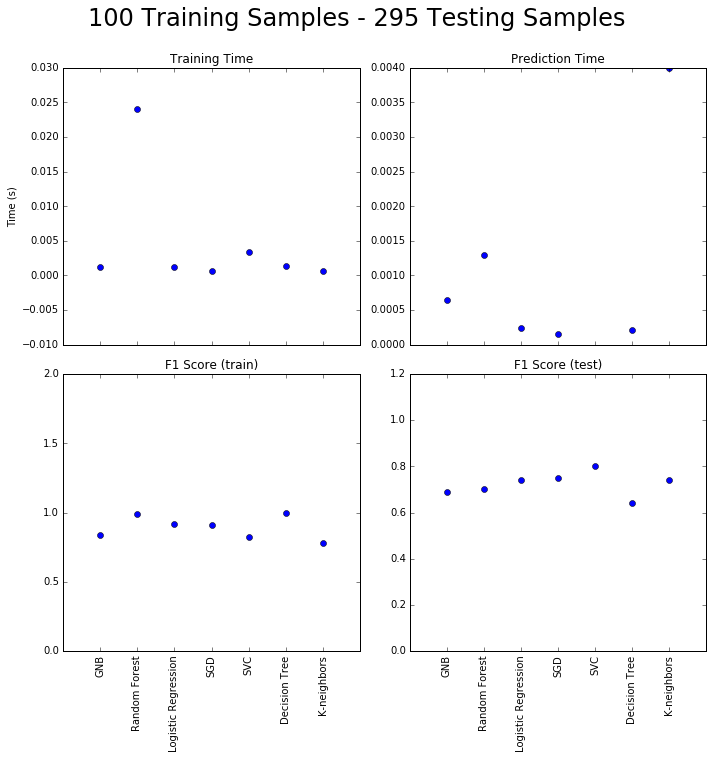

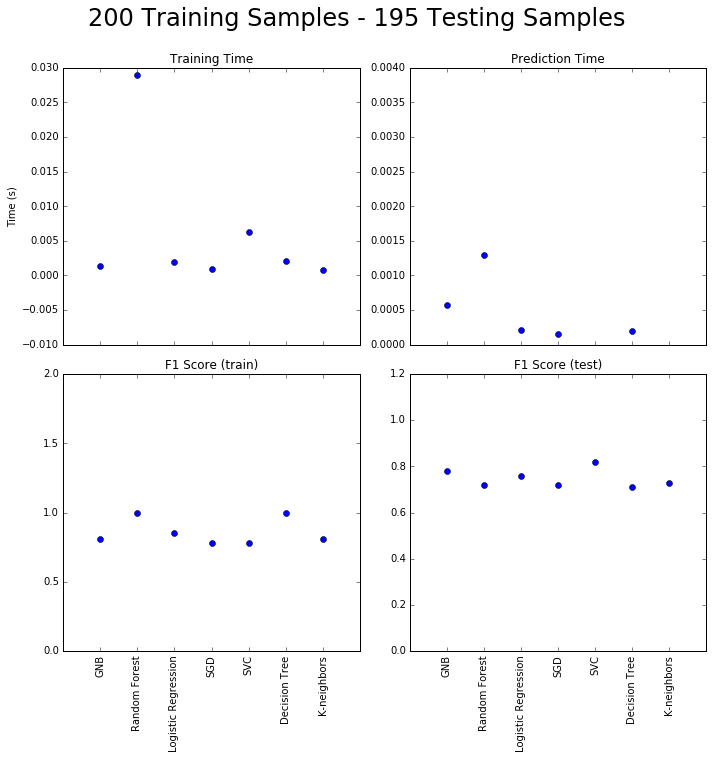

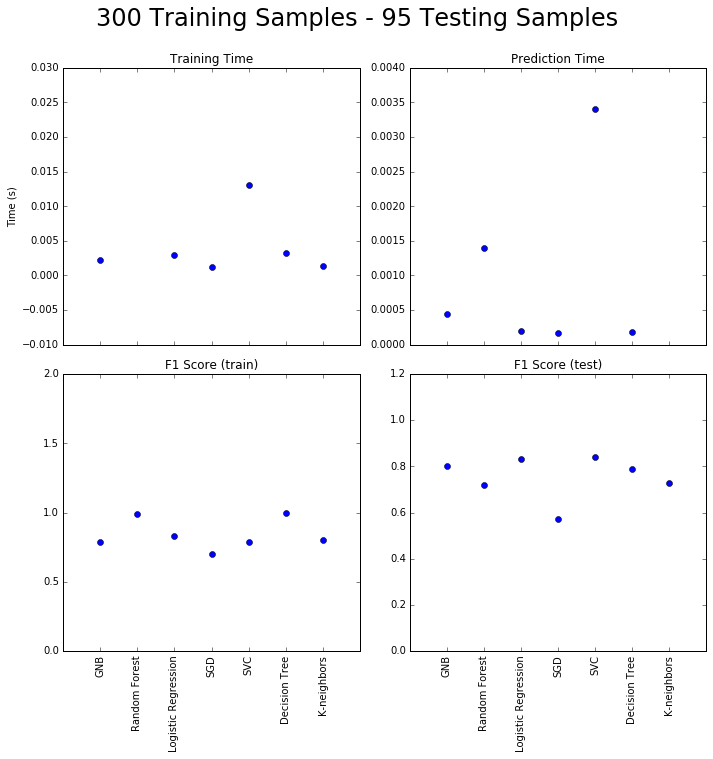

In [15]:
import matplotlib.pyplot as plt

labels = ['GNB',  'Random Forest', 'Logistic Regression', 'SGD', 'SVC','Decision Tree', 'K-neighbors']

xvalues=np.arange(0,len(finaltablelist))

ytrainingtime=[[] for i in range(3)]
ypredictiontime=[[] for i in range(3)]
yf1train=[[] for i in range(3)]
yf1test=[[] for i in range(3)]

for j in range(3):

    fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex=True, figsize=(10,10))
    plt.xticks(xvalues, labels, rotation='vertical')
    
    
    ntrain=(j+1)*100
    ntest=395-ntrain
    
    traintext,testtext=str(ntrain),str(ntest)
    
    titleglobal=traintext+' Training Samples - '+ testtext + ' Testing Samples'
    
    plt.suptitle(titleglobal, y=1.05, fontsize=24)
    
   
    for i in range(7):

        ytrainingtime[j].append(finaltablelist[i][j][1])
        ypredictiontime[j].append(finaltablelist[i][j][2])
        yf1train[j].append(finaltablelist[i][j][3])
        yf1test[j].append(finaltablelist[i][j][4])
        
    ax1.set_ylabel('Time (s)')
    ax1.set_title('Training Time')
    ax2.set_title('Prediction Time')
    ax3.set_title('F1 Score (train)')
    ax4.set_title('F1 Score (test)')


    ax4.set_xticklabels(labels, rotation='vertical')
    ax3.set_xticklabels(labels, rotation='vertical')

    ax1.plot(xvalues, ytrainingtime[j], 'bo')
    ax2.plot(xvalues, ypredictiontime[j], 'bo')
    ax3.plot(xvalues, yf1train[j], 'bo')
    ax4.plot(xvalues, yf1test[j], 'bo')

    ax1.set_ylim([-0.01, 0.03])
    ax2.set_ylim([0, 0.004])
    ax3.set_ylim([0, 2])
    ax4.set_ylim([0,1.2])

    ax1.set_xlim([-1, 7])

    plt.tight_layout()
    plt.show()


K Nearest Neighbors (KNN) is discarded because it consumes more resources than SVC in predicting and delivers slightly worse results. Random Forest (RF) does not improve DT accuracy or overfitting and adds processing time. SGB seems to have problems with convergence and scores poorly. These results mirror the analysis provided in the Model Application section.

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

__OBSERVATION__: We now focus on the five selected models: SGD, SVC, Decision Tree, Logistic Regression and GNB.

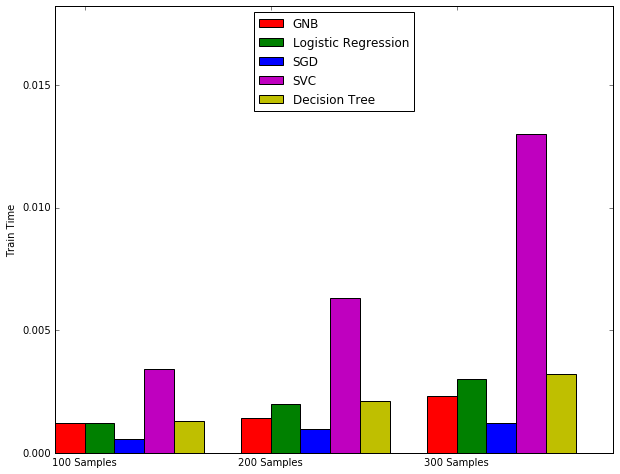

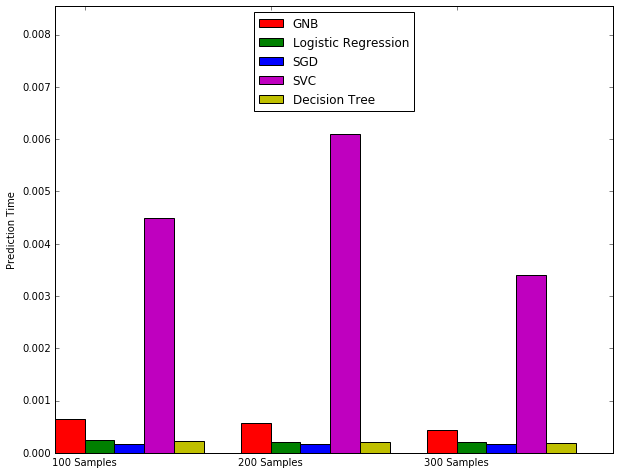

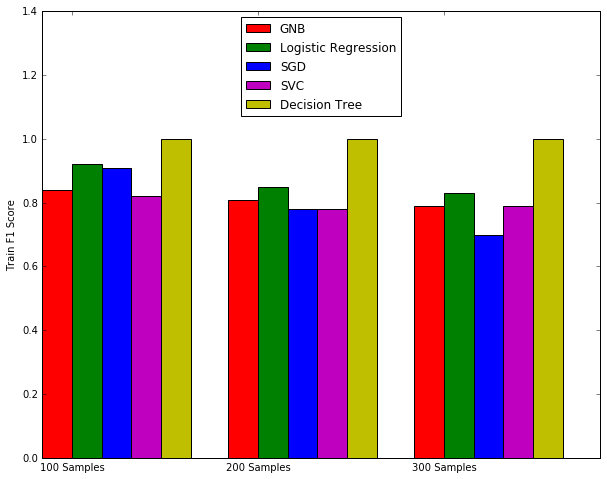

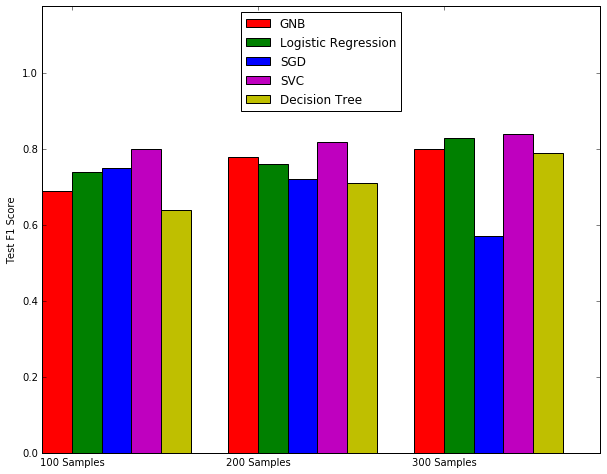

In [16]:
labels2 = ['Train Time',  'Prediction Time', 'Train F1 Score','Test F1 Score']

xvalues=np.arange(0,len(finaltablelist))

yval_f=[[[] for i in range(5)] for j in range(4)]

for j, item in enumerate([0,2,3,4,5]):
    
    for i in range(3) :
        
        for k in range(4):
        
            yval_f[k][j].append(finaltablelist[item][i][k+1])
        

for m in range(4):

    N = 3
    ind = np.arange(N)  # the x locations for the groups
    width = 0.16       # the width of the bars

    figx = plt.figure(figsize=(10,8))
    ax = figx.add_subplot(111)

    y1vals = yval_f[m][0]
    rects1 = ax.bar(ind, y1vals, width, color='r')
    y2vals = yval_f[m][1]
    rects2 = ax.bar(ind+width, y2vals, width, color='g')
    y3vals = yval_f[m][2]
    rects3 = ax.bar(ind+width*2, y3vals, width, color='b')
    y4vals = yval_f[m][3]
    rects4 = ax.bar(ind+width*3, y4vals, width, color='m')
    y5vals = yval_f[m][4]
    rects5 = ax.bar(ind+width*4, y5vals, width, color='y')


    ax.set_ylabel(labels2[m])
    ax.set_xticks(ind+width)
    ax.set_xticklabels( ('100 Samples', '200 Samples', '300 Samples') )
    ax.legend((rects1[0], rects2[0], rects3[0], rects4[0],rects5[0]), ('GNB', 'Logistic Regression','SGD','SVC', 'Decision Tree'),loc='upper center' )
    ax.set_ylim([0, 0.01])
    

    high =float(max(y1vals+y2vals+y3vals+y4vals+y5vals))

    plt.ylim(0, high*1.4)

    plt.show()

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

__OBSERVATION__: The results are dependent on the random state selected. Usually the models are run using different random state values and an average is taken. The pseudo randomnes is set constant for comparison between models, but the reality is that the results depend on the seed selected. For the purposses of this analysis we chose the seed (random state value) that representes the most likely result out of 10 different values run (not shown).

**Answer: **

SVC has the highest score among the models and across the different sample training sizes. In a very close second place was LR. However, SVC's computational training cost increases exponentially with training sample size and the prediction time is around 8X the average of other models and thus discarded. Decision Tree was also discarded because despite its fast processing time it underperformed LR and GNB. In turn, GNB underperformed LR.

__Greatest Performance Solution__: SVC and LR is the choice for an implementation, with SVC being the costyl option.

__Cost Critical Solution__: LR provides the second best score with fast training and prediction times.

Implementing SVC represents a 1-3 percent increase in F1 score (accuracy) which means 4-12 additional students correctly classified, but since the goal is to help __decrease the number of students failing the class__, the cost/benefit analysis should include the resources invested in failing students and determine whether the savings in correctly predicting them would offset the cost of using SVC as the predictive algorithm. 

__Final Model Selection__ The final selected model is LR. However, its performance should be periodically analyzed against SVC to determine, as more data is acquired, if it remains the best option.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

Every model evaluated in this work follow the same general behavior. The differences between them lie on the 'how' rather than the 'what'.

The dataset contains features for every student. We can start by thinking of a map, that we will call feature map, where each student is represented by a dot. The positions of these dots on the map depend on their feature values. Students with similar features will naturally group in certain locations. Ideally the groups are well defined but real world problems present a certain degree of overlapping between groups. Thus, the job of the algorithm is to draw the best border line that will divide the map into two regions: one region populated with students that passed and another region with students that didn't (in reality, due to overlapping, the model needs to minimize the overlapping between groups in order to increase accuracy). Once these two regions are defined during the training stage, the model can 'predict' whether new students will fail or not depending on their position in the feature map. The different techniques differ in how they separate these two regions: continuous lines, continuos curves, square areas or even disconnected closed areas.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

__OBSERVATION__ Grid search for SVC and SGD will be done for comparison.

### Logistic Regression Grid Search

In [17]:
# TODO: Import 'GridSearchCV' and 'make_scorer'

from sklearn import grid_search
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune

#parameters = {'C': np.arange(1,1.5,0.01), 'gamma': np.arange(0, 0.1, 0.01),'kernel':("rbf","linear", "sigmoid")}
parameters1 = {'C': np.arange(1,1.5,0.01), 'penalty': ("l1","l2")}
#parameters = {'loss': ("hinge", "log", "modified_huber", "squared_hinge", "perceptron") , 'penalty': ("l1","l2")}

# TODO: Initialize the classifier

#clf = SVC(random_state=rstate)
clf1=LogisticRegression(random_state=rstate)
#clf=SGDClassifier(random_state=rstate, n_jobs=-1)


# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label="yes")

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = grid_search.GridSearchCV(clf1,parameters1, scoring=f1_scorer, n_jobs=-1) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train_300,y_train_300)

# Get the estimator
clf1f = grid_obj.best_estimator_

X_train, y_train, X_test, y_test=X_train_300,y_train_300,X_test_95,y_test_95

# Report the final F1 score for training and testing after parameter tuning
print "best parameters", grid_obj.best_params_
#print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a training F1 score of {:.4f}.",predict_labels(clf1f, X_train, y_train)
print "Tuned model has a testing F1 score of {:.4f}.", predict_labels(clf1f, X_test, y_test)

best parameters {'penalty': 'l1', 'C': 1.0}
Tuned model has a training F1 score of {:.4f}. Made predictions in 0.0003 seconds.
(0.83371298405466976, 0.0003190040588378906)
Tuned model has a testing F1 score of {:.4f}. Made predictions in 0.0002 seconds.
(0.82993197278911557, 0.00015306472778320312)


### SVC Grid Search

In [18]:
# TODO: Import 'GridSearchCV' and 'make_scorer'

from sklearn import grid_search
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune

parameters0 = {'C': np.arange(1,1.5,0.01), 'gamma': np.arange(0, 0.1, 0.01),'kernel':("rbf","linear", "sigmoid")}
#parameters = {'C': np.arange(1,1.5,0.01), 'penalty': ("l1","l2")}
#parameters = {'loss': ("hinge", "log", "modified_huber", "squared_hinge", "perceptron") , 'penalty': ("l1","l2")}


# TODO: Initialize the classifier

clf0 = SVC(random_state=rstate)
#clf=LogisticRegression(random_state=rstate, n_jobs=-1)
#clf=SGDClassifier(random_state=rstate, n_jobs=-1)



# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label="yes")

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = grid_search.GridSearchCV(clf0,parameters0, scoring=f1_scorer, n_jobs=-1) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train_300,y_train_300)

# Get the estimator
clf0f = grid_obj.best_estimator_

X_train, y_train, X_test, y_test=X_train_300,y_train_300,X_test_95,y_test_95

# Report the final F1 score for training and testing after parameter tuning
print "best parameters", grid_obj.best_params_
#print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a training F1 score of {:.4f}.",predict_labels(clf0f, X_train, y_train)
print "Tuned model has a testing F1 score of {:.4f}.", predict_labels(clf0f, X_test, y_test)

best parameters {'kernel': 'rbf', 'C': 1.3000000000000003, 'gamma': 0.050000000000000003}
Tuned model has a training F1 score of {:.4f}. Made predictions in 0.0126 seconds.
(0.82127659574468082, 0.012588024139404297)
Tuned model has a testing F1 score of {:.4f}. Made predictions in 0.0040 seconds.
(0.81045751633986929, 0.003980875015258789)


### SGD Grid Search

In [19]:
# TODO: Import 'GridSearchCV' and 'make_scorer'

from sklearn import grid_search
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune

#parameters = {'C': np.arange(1,1.5,0.01), 'gamma': np.arange(0, 0.1, 0.01),'kernel':("rbf","linear", "sigmoid")}
#parameters = {'C': np.arange(1,1.5,0.01), 'penalty': ("l1","l2")}
parameters2 = {'loss': ("hinge", "log", "modified_huber", "squared_hinge", "perceptron") , 'penalty': ("l1","l2")}

# TODO: Initialize the classifier

#clf = SVC(random_state=rstate)
#clf=LogisticRegression(random_state=rstate, n_jobs=-1)
clf2=SGDClassifier(random_state=rstate)


# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label="yes")

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = grid_search.GridSearchCV(clf2,parameters2, scoring=f1_scorer, n_jobs=-1) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train_300,y_train_300)

# Get the estimator
clf2f = grid_obj.best_estimator_

X_train, y_train, X_test, y_test=X_train_300,y_train_300,X_test_95,y_test_95

# Report the final F1 score for training and testing after parameter tuning
print "best parameters", grid_obj.best_params_
#print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a training F1 score of {:.4f}.",predict_labels(clf2f, X_train, y_train)
print "Tuned model has a testing F1 score of {:.4f}.", predict_labels(clf2f, X_test, y_test)

best parameters {'penalty': 'l1', 'loss': 'perceptron'}
Tuned model has a training F1 score of {:.4f}. Made predictions in 0.0004 seconds.
(0.7142857142857143, 0.0003921985626220703)
Tuned model has a testing F1 score of {:.4f}. Made predictions in 0.0001 seconds.
(0.65486725663716827, 0.00013303756713867188)


LR outperforms SVC after Grid Search. Most likely the result of not quite using the same parameters in the grid parameter search. The same would apply to SGD.

### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **


The training F1 score is 0.834 and testing F1 score is 0.830. The score does not improve after tuning. The training score mirrors the testing score, indicating the model is actually learning the right patterns from the training set 

It can be seen that the tuning of the model usually (not always) has a smaller impact on the accuracy than feature engineering or model selection. GridSearch should be continuosly used to fine tune he model as the features and model selection evolve.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.